In [1]:
# conda create --name census python=3.9
# conda activate census
# pip install numpy matplotlib pandas seaborn scikit-learn aif360 lime tensorflow fairlearn

In [57]:
from collections import defaultdict
import os
import platform

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import aif360
from aif360.datasets import StandardDataset
from aif360.datasets.lime_encoder import LimeEncoder
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.explainers import MetricTextExplainer
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

import lime
from lime.lime_tabular import LimeTabularExplainer

import sklearn
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

print(f"python = {platform.python_version()}")
print(f"matplotlib = {matplotlib.__version__}")
print(f"numpy = {np.__version__}")
print(f"pandas = {pd.__version__}")
print(f"seaborn = {sns.__version__}")
print(f"aif360 = {aif360.__version__}")
print(f"lime = 0.2.0.1")
print(f"sklearn = {sklearn.__version__}")

%matplotlib inline

python = 3.9.7
matplotlib = 3.4.3
numpy = 1.21.2
pandas = 1.4.0
seaborn = 0.11.2
aif360 = 0.4.0
lime = 0.2.0.1
sklearn = 1.0.2


In [3]:
PATH = "census-income.csv"
df = pd.read_csv(PATH, low_memory=False)

Preprocess the data
- `numerical_cols`: Convert column to float
- `categorical_cols`: Convert column to category
- `categorical_missing_cols`: Convert column to category and add a new binary column for missing values
- Some rows use a different value for missing data. So convert all these values to `Not in universe`
- There are 867 rows with missing values and these are just removed from the dataset'
- `instance weight` is not removed in this step. It will be removed when we split data into train/val/test

In [4]:
# Handle special cases
df = df.dropna()
df['major industry code'] = df['major industry code'].replace({"Not in universe or children": "Not in universe"})
df['live in this house 1 year ago'] = df['live in this house 1 year ago'].replace({"Not in universe under 1 year old": "Not in universe"})
df['own business or self employed'] = df['own business or self employed'].replace({0: "Not in universe"})
df = df.rename(columns={"fill inc questionnaire for veteran's admin": "fill inc questionnaire for veteran admin"})


# Convert dtype of col from `int64` to `float64` and use sklearn `MinMaxScaler`
numerical_cols = ['age', 'detailed industry recode', 'detailed occupation recode', 'wage per hour',
                  'capital gains', 'capital losses', 'dividends from stocks']

for col in numerical_cols:
    df[col] = df[col].values.astype('float')
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


# Convert dtype of col to `category`
categorical_cols = ['class of worker', 'education', 'marital stat', 'race', 'hispanic origin',
                    'sex', 'full or part time employment stat', 'tax filer stat', 'detailed household and family stat',
                    'detailed household summary in household', 'num persons worked for employer', 'country of birth father',
                    'country of birth mother', 'country of birth self', 'citizenship', 'veterans benefits', 'year', 'label']

for col in categorical_cols:
    df[col] = df[col].astype('category')
df = pd.get_dummies(df, columns=categorical_cols[:-1])

# Convert dtype of col to `category` and add a new binary column with 1 (Not in universe) and 0 for all other values
categorical_missing_cols = ['enroll in edu inst last wk', 'major industry code', 'major occupation code',
                            'member of a labor union', 'reason for unemployment', 'region of previous residence',
                            'state of previous residence', 'migration code-change in msa', 'migration code-change in reg',
                            'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt',
                            'family members under 18', 'own business or self employed', 'fill inc questionnaire for veteran admin',
                            'weeks worked in year']

for col in categorical_missing_cols:
    df[col] = df[col].astype('category')
    df[f"{col}_imputed"] = np.where(df[col] == "Not in universe", 1, 0)
    df[f"{col}_imputed"] = df[f"{col}_imputed"].astype('category')
df = pd.get_dummies(df, columns=categorical_missing_cols)

# Labelencode the label column
label_encoder = LabelEncoder()
label_encoder.fit(df['label'].values)
df.loc[:,'label'] = label_encoder.transform(df['label'].values)

Split the dataset into train/val/test. Also, remove `instance weight` from the data.

In [5]:
TRAIN = 0.7
VAL = 0.15
TEST = 0.15

train_df, temp_df = train_test_split(df, test_size=VAL+TEST, shuffle=True, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=TEST/(VAL+TEST), shuffle=True, random_state=42)

def get_x_y_iw(df):
    df = df.reset_index(drop=True)
    iw = df['instance weight']
    y = df['label']
    
    df = df.drop('instance weight', axis=1)
    df = df.drop('label', axis=1)
    
    return df, y, iw

train_x, train_y, train_iw = get_x_y_iw(train_df)
val_x, val_y, val_iw = get_x_y_iw(val_df)
test_x, test_y, test_iw = get_x_y_iw(test_df)

def print_shapes(df, x, y, name):
    print(f"{name}_df.shape = {df.shape}")
    print(f"{name}_x.shape = {x.shape}")
    print(f"{name}_y.shape = {y.shape}")
    print()
    

print_shapes(train_df, train_x, train_y, "train")
print_shapes(val_df, val_x, val_y, "val")
print_shapes(test_df, test_x, test_y, "test")

train_df.shape = (139054, 488)
train_x.shape = (139054, 486)
train_y.shape = (139054,)

val_df.shape = (29797, 488)
val_x.shape = (29797, 486)
val_y.shape = (29797,)

test_df.shape = (29798, 488)
test_x.shape = (29798, 486)
test_y.shape = (29798,)



Train a random forest model and use RandomSearch to get optimal hyperparameter values. **F-score** is used as the validation metric because the output label distribution is highly imbalanced (130524 negative labels and 8530 positive labels for `train_y`.

In [6]:
# The hyperparameter values were obtained from RandomSearchCV using train and val split
clf = RandomForestClassifier(n_estimators=150,
                             min_samples_split=5,
                             min_samples_leaf=1,
                             max_features='sqrt',
                             max_depth=70,
                             bootstrap=False,
                             n_jobs=-1)
clf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=False, max_depth=70, max_features='sqrt',
                       min_samples_split=5, n_estimators=150, n_jobs=-1)

In [7]:
def f1_score(x, y):
    y_pred = clf.predict(x)
    f1 = metrics.f1_score(y, y_pred)
    return f1

print(f"train f1_score = {f1_score(train_x, train_y)}")
print(f"val f1_score = {f1_score(val_x, val_y)}")
print(f"test f1_score = {f1_score(test_x, test_y)}")

train f1_score = 0.9759664369193887
val f1_score = 0.5166025865082138
test f1_score = 0.4933145672061928


Use validation split to get the optimal threshold value for binary classification.

In [8]:
best_thresh, best_f1 = -1, -1
val_y_proba = clf.predict_proba(val_x)

for thresh in np.linspace(0, 1, 100):
    val_y_pred = (val_y_proba[:,1] >= thresh).astype(np.float64)
    f1 = metrics.f1_score(val_y, val_y_pred)
    
    if f1 > best_f1:
        best_thresh = thresh
        best_f1 = f1

print(f"The best threshold value = {best_thresh} and best f1 score = {best_f1}")

The best threshold value = 0.30303030303030304 and best f1 score = 0.6062322946175638


In [10]:
def optimal_f1_score(x, y, thresh=0.30303):
    y_proba = clf.predict_proba(x)
    y_pred = (y_proba[:,1] >= thresh).astype(np.float64)
    f1 = metrics.f1_score(y, y_pred)
    return f1

print(f"train optimal_f1_score = {optimal_f1_score(train_x, train_y)}")
print(f"val optimal_f1_score = {optimal_f1_score(val_x, val_y)}")
print(f"test optimal_f1_score = {optimal_f1_score(test_x, test_y)}")

train optimal_f1_score = 0.9788898475697441
val optimal_f1_score = 0.6062322946175638
test optimal_f1_score = 0.5885142255005268


Plot the importance of each feature and then use this info to find the most *sensitive* feature.

In [65]:
feature_imp = pd.Series(clf.feature_importances_, index=train_x.columns).sort_values(ascending=False)
print(feature_imp)

dividends from stocks                                                             0.082523
capital gains                                                                     0.077883
age                                                                               0.068054
detailed occupation recode                                                        0.064996
detailed industry recode                                                          0.035521
                                                                                    ...   
detailed household and family stat_Grandchild <18 ever marr not in subfamily      0.000000
detailed household and family stat_Other Rel <18 never married RP of subfamily    0.000000
detailed household and family stat_Other Rel <18 spouse of subfamily RP           0.000000
detailed household and family stat_Grandchild <18 never marr RP of subfamily      0.000000
detailed household and family stat_Other Rel <18 ever marr not in subfamily       0.000000

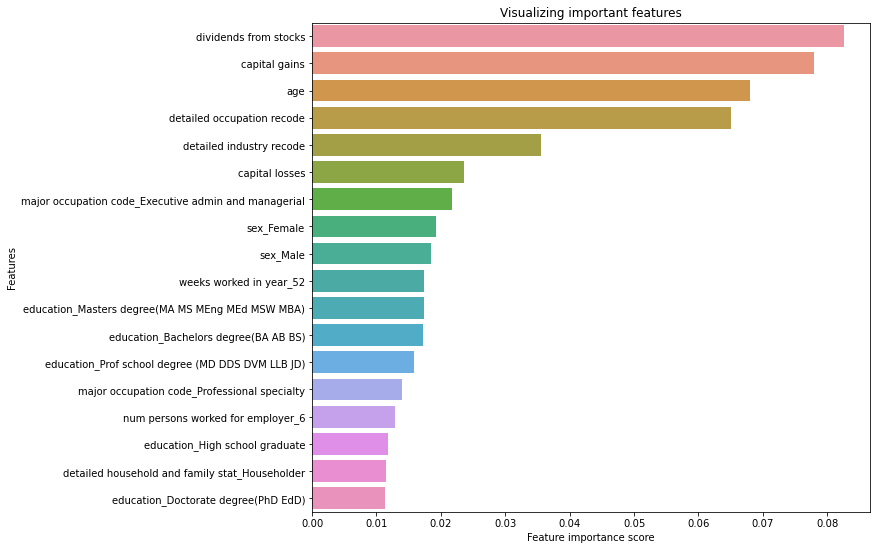

In [66]:
# Only plot the features whose importance is greater than 0.01
feature_imp = feature_imp[feature_imp >= 0.01]

fig, ax = plt.subplots(figsize=(10, 9))
sns.barplot(x=feature_imp, y=feature_imp.index, ax=ax)
plt.xlabel("Feature importance score")
plt.ylabel("Features")
plt.title("Visualizing important features")
plt.show()

Create new datasets with only the above features and with sensitive feature = `age`.

In [79]:
train_x = train_x[feature_imp.index]
val_x = val_x[feature_imp.index]
test_x = test_x[feature_imp.index]

In [11]:
# Save the data for future use
# os.makedirs("data", exist_ok=True)

# train_x.to_csv("data/train_x.csv", index=False)
# train_y.to_csv("data/train_y.csv", index=False)
# train_iw.to_csv("data/train_iw.csv", index=False)

# val_x.to_csv("data/val_x.csv", index=False)
# val_y.to_csv("data/val_y.csv", index=False)
# val_iw.to_csv("data/val_iw.csv", index=False)

# test_x.to_csv("data/test_x.csv", index=False)
# test_y.to_csv("data/test_y.csv", index=False)
# test_iw.to_csv("data/test_iw.csv", index=False)

# Load data
# train_x = pd.read_csv("data/train_x.csv", low_memory=False)
# train_y = pd.read_csv("data/train_y.csv", low_memory=False)
# train_iw = pd.read_csv("data/train_iw.csv", low_memory=False)

# val_x = pd.read_csv("data/val_x.csv", low_memory=False)
# val_y = pd.read_csv("data/val_y.csv", low_memory=False)
# val_iw = pd.read_csv("data/val_iw.csv", low_memory=False)

# test_x = pd.read_csv("data/test_x.csv", low_memory=False)
# test_y = pd.read_csv("data/test_y.csv", low_memory=False)
# test_iw = pd.read_csv("data/test_iw.csv", low_memory=False)

## Bias mitigation

Create dataset class and set appropriate variables.

In [12]:
class Dataset(StandardDataset):
    def __init__(self, x, y, iw):
        df = x
        df['label'] = y
        df['instance weight'] = iw
        super().__init__(df=df, label_name='label', favorable_classes=[1],
                         protected_attribute_names=['age'], privileged_classes=[lambda x: x >= 0.5],
                         instance_weights_name='instance weight')

In [13]:
train_dataset = Dataset(train_x, train_y, train_iw)
val_dataset = Dataset(val_x, val_y, val_iw)
test_dataset = Dataset(test_x, test_y, test_iw)

sens_ind = 0
sens_attr = 'age'
unprivileged_groups = [{'age': 0.0}]
privileged_groups = [{'age': 1.0}]

In [14]:
metric_train_dataset = BinaryLabelDatasetMetric(train_dataset,
                                                unprivileged_groups=unprivileged_groups,
                                                privileged_groups=privileged_groups)
explainer_train_dataset = MetricTextExplainer(metric_train_dataset)

print(explainer_train_dataset.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.421228221922324


## Base RandomForestModel

Train a RandomForest model (the same hyperparameters are used as found with RandomSearchCV).

In [15]:
dataset = train_dataset
model = make_pipeline(RandomForestClassifier(n_estimators=150,
                                             min_samples_split=5,
                                             min_samples_leaf=1,
                                             max_features='sqrt',
                                             max_depth=70,
                                             bootstrap=False,
                                             n_jobs=-1))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
clf = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

Validate the model by finding the optimal threshold value for classification.

In [16]:
def test(dataset, model, thresh_arr):
    try:
        y_proba = model.predict_proba(dataset.features)
        pos_ind = 1
    except AttributeError:
        y_proba = model.predict(dataset).scores
        pos_ind = 0

    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_pred = (y_proba[:,pos_ind] >= thresh).astype(np.float64)
        
        dataset_pred = dataset.copy()
        dataset_pred.labels = y_pred
        metric = ClassificationMetric(dataset, dataset_pred, unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    return metric_arrs

In [17]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=val_dataset, model=clf, thresh_arr=thresh_arr)
val_best_ind = np.argmax(val_metrics['bal_acc'])

Plot metrics.

In [18]:
def plot(x, x_name, y_left, y_left_name, y_right, y_right_name):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    # ax1.set_ylim(0.5, 0.8)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.7)
    else:
        ax2.set_ylim(-0.25, 0.1)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)

Here we plot `1−min(disparate impact,1/disparate impact)` since it's possible to overcorrect and end up with a value greater than 1, implying unfairness for the original privileged group. For shorthand, we simply call this `1-min(DI, 1/DI)` from now on. We want the plotted metric to be less than 0.2.

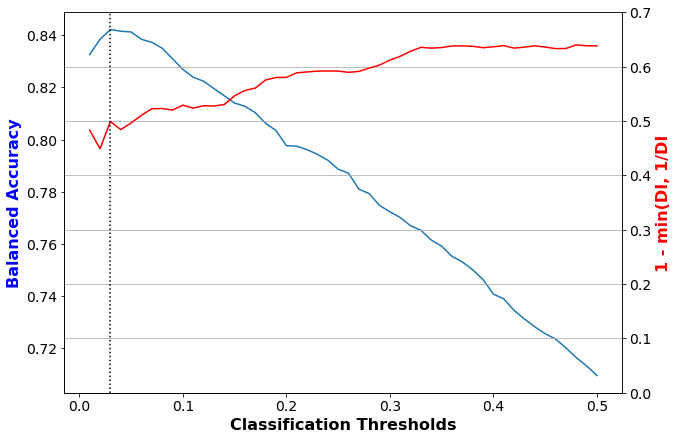

In [19]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI')

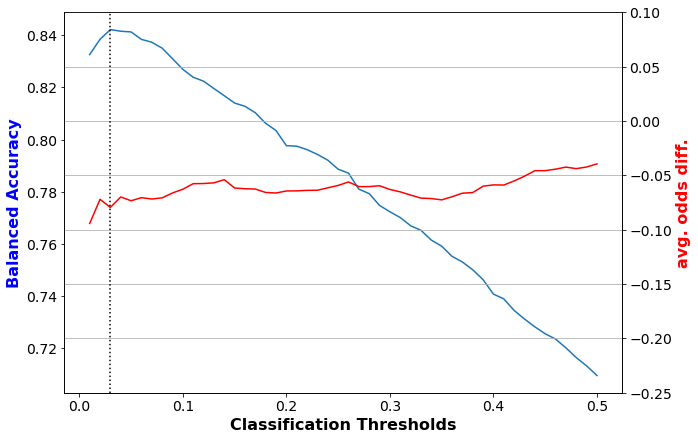

In [20]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

Helper function to print out accuracy and fairness metrics.

In [21]:
def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
#     disp_imp_at_best_ind = np.abs(1 - np.array(metrics['disp_imp']))[best_ind]
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))

In [22]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.0300
Best balanced accuracy: 0.8422
Corresponding 1-min(DI, 1/DI) value: 0.4990
Corresponding average odds difference value: -0.0795
Corresponding statistical parity difference value: -0.1577
Corresponding equal opportunity difference value: -0.0371
Corresponding Theil index value: 0.0511


For all the fairness metrics displayed above, the value should be close to '0' for fairness.

1-min(DI, 1/DI) < 0.2 is typically desired for classifier predictions to be fair. However, in our case the best classification rate is quite high. This implies unfairness.

Similarly, average odds difference must be close to zero for the classifier to be fair.

In [23]:
# Test the model on test dataset.
test_metrics = test(dataset=test_dataset, model=clf, thresh_arr=[thresh_arr[val_best_ind]])

describe_metrics(test_metrics, [thresh_arr[val_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.0300
Best balanced accuracy: 0.8428
Corresponding 1-min(DI, 1/DI) value: 0.4816
Corresponding average odds difference value: -0.0846
Corresponding statistical parity difference value: -0.1517
Corresponding equal opportunity difference value: -0.0507
Corresponding Theil index value: 0.0523


Again we can see the model is unfair.

## Base LogisticRegression model

In [24]:
dataset = train_dataset
model = make_pipeline(LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
clf = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

In [25]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=val_dataset, model=clf, thresh_arr=thresh_arr)
val_best_ind = np.argmax(val_metrics['bal_acc'])

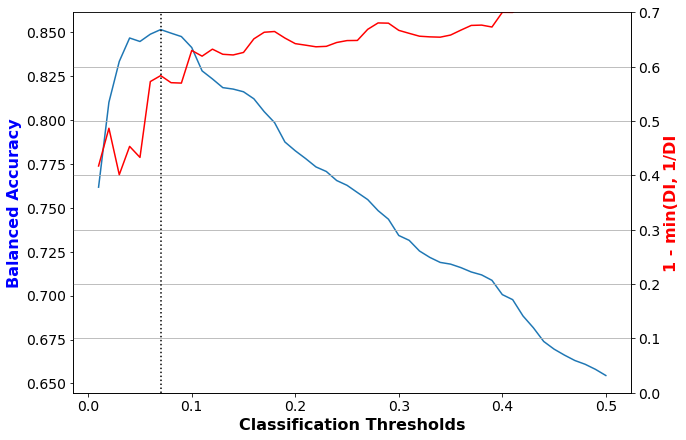

In [26]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI')

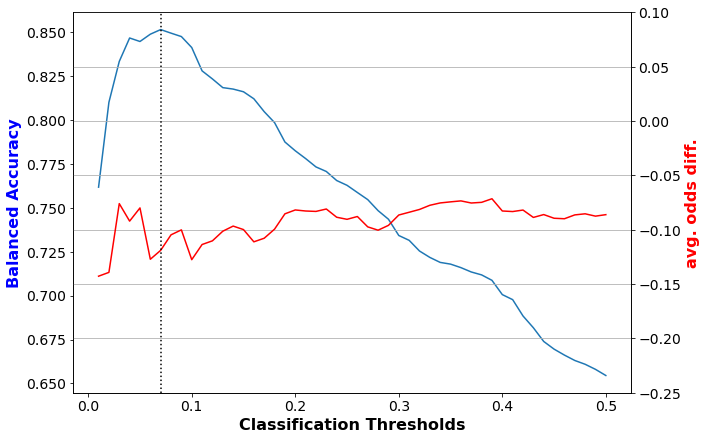

In [27]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [28]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.0700
Best balanced accuracy: 0.8513
Corresponding 1-min(DI, 1/DI) value: 0.5835
Corresponding average odds difference value: -0.1190
Corresponding statistical parity difference value: -0.1831
Corresponding equal opportunity difference value: -0.0940
Corresponding Theil index value: 0.0478


In [29]:
# Test the model on test dataset.
base_lg_test_metrics = test(dataset=test_dataset, model=clf, thresh_arr=[thresh_arr[val_best_ind]])

describe_metrics(base_lg_test_metrics, [thresh_arr[val_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.0700
Best balanced accuracy: 0.8418
Corresponding 1-min(DI, 1/DI) value: 0.5660
Corresponding average odds difference value: -0.1278
Corresponding statistical parity difference value: -0.1723
Corresponding equal opportunity difference value: -0.1201
Corresponding Theil index value: 0.0495


## Bias mitigation using Reweighting (RandomForest)

In [30]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
reweighted_train_dataset = RW.fit_transform(train_dataset)

In [31]:
metric_reweighted_train_dataset = BinaryLabelDatasetMetric(reweighted_train_dataset,
                                                           unprivileged_groups=unprivileged_groups,
                                                           privileged_groups=privileged_groups)
explainer_reweighted_train_dataset = MetricTextExplainer(metric_reweighted_train_dataset)

print(explainer_reweighted_train_dataset.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0000000000000002


Train a RandomForest model on Reweighted Data and get the new metrics.

In [32]:
dataset = reweighted_train_dataset
model = make_pipeline(RandomForestClassifier(n_estimators=150,
                                             min_samples_split=5,
                                             min_samples_leaf=1,
                                             max_features='sqrt',
                                             max_depth=70,
                                             bootstrap=False,
                                             n_jobs=-1))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
clf = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

In [33]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=val_dataset, model=clf, thresh_arr=thresh_arr)
val_best_ind = np.argmax(val_metrics['bal_acc'])

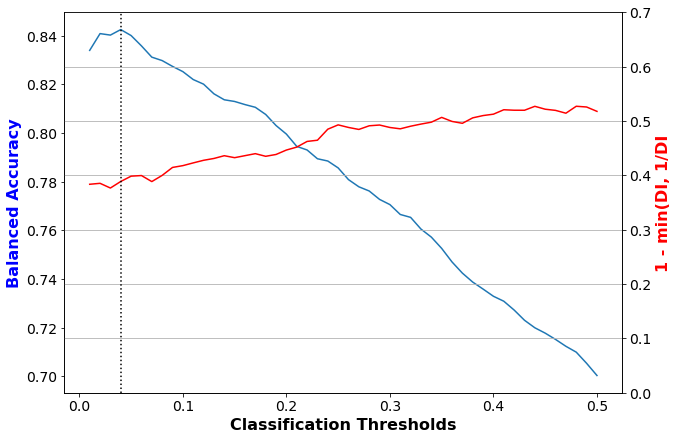

In [34]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI')

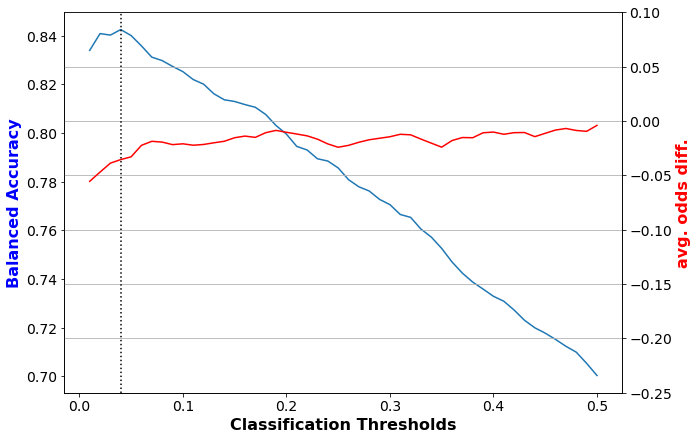

In [35]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [36]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.0400
Best balanced accuracy: 0.8425
Corresponding 1-min(DI, 1/DI) value: 0.3887
Corresponding average odds difference value: -0.0355
Corresponding statistical parity difference value: -0.1014
Corresponding equal opportunity difference value: -0.0085
Corresponding Theil index value: 0.0496


In [37]:
# Test the model on test dataset.
rw_test_metrics = test(dataset=test_dataset, model=clf, thresh_arr=[thresh_arr[val_best_ind]])

describe_metrics(rw_test_metrics, [thresh_arr[val_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.0400
Best balanced accuracy: 0.8442
Corresponding 1-min(DI, 1/DI) value: 0.3533
Corresponding average odds difference value: -0.0387
Corresponding statistical parity difference value: -0.0893
Corresponding equal opportunity difference value: -0.0253
Corresponding Theil index value: 0.0499


The results of reweighting are summarized as follows
- `1-min(DI, 1/DI)` value decreased from 0.4816 to 0.3533 (as the value got closer to zero, this implies the model got lest unfair)
- The average odds difference increased from -0.0846 to -0.0387 (as the value got closer to zero, this implies the model got less unfair)

## Bias mitigiation using Reweighting (LogisticRegression)

In [38]:
dataset = reweighted_train_dataset
model = make_pipeline(LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
clf = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

In [39]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=val_dataset, model=clf, thresh_arr=thresh_arr)
val_best_ind = np.argmax(val_metrics['bal_acc'])

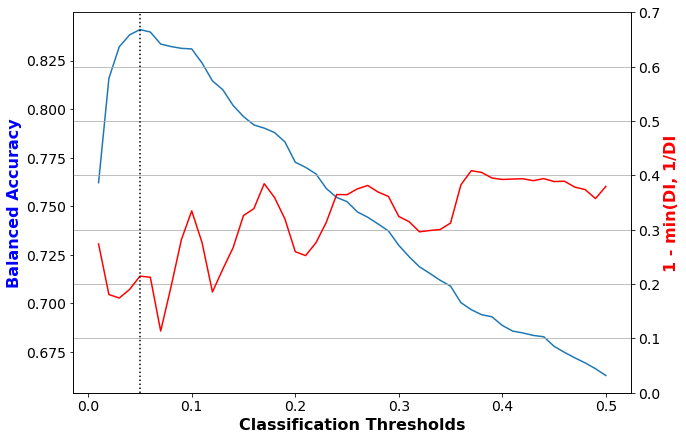

In [40]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI')

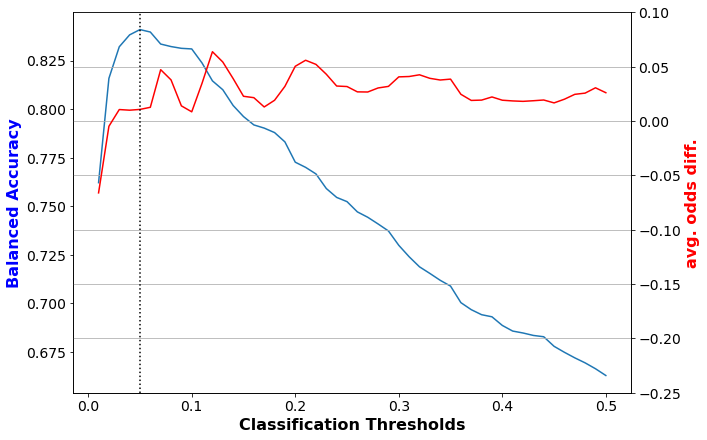

In [41]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [42]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.0500
Best balanced accuracy: 0.8410
Corresponding 1-min(DI, 1/DI) value: 0.2146
Corresponding average odds difference value: 0.0106
Corresponding statistical parity difference value: -0.0623
Corresponding equal opportunity difference value: 0.0454
Corresponding Theil index value: 0.0545


In [43]:
# Test the model on test dataset.
rw_lg_test_metrics = test(dataset=test_dataset, model=clf, thresh_arr=[thresh_arr[val_best_ind]])

describe_metrics(rw_lg_test_metrics, [thresh_arr[val_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.0500
Best balanced accuracy: 0.8422
Corresponding 1-min(DI, 1/DI) value: 0.1526
Corresponding average odds difference value: 0.0226
Corresponding statistical parity difference value: -0.0420
Corresponding equal opportunity difference value: 0.0522
Corresponding Theil index value: 0.0552


## Bias mitgation using Prejudice Remover

In [44]:
model = PrejudiceRemover(sensitive_attr=sens_attr, eta=25.0)
dataset = train_dataset.copy()
model = model.fit(dataset)

In [45]:
thresh_arr = np.linspace(0.01, 0.50, 50)

dataset = val_dataset.copy()
val_metrics = test(dataset=dataset, model=model, thresh_arr=thresh_arr)
val_best_ind = np.argmax(val_metrics['bal_acc'])

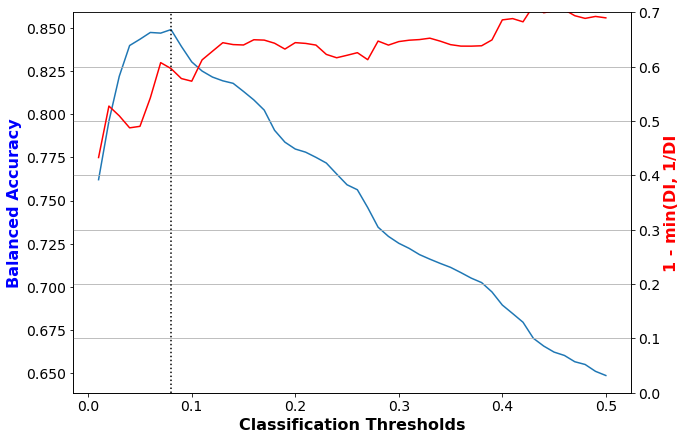

In [46]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI')

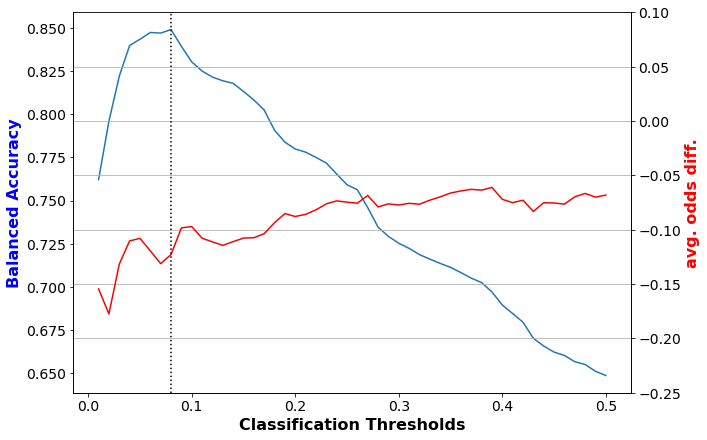

In [47]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [48]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.0800
Best balanced accuracy: 0.8492
Corresponding 1-min(DI, 1/DI) value: 0.5965
Corresponding average odds difference value: -0.1228
Corresponding statistical parity difference value: -0.1830
Corresponding equal opportunity difference value: -0.1023
Corresponding Theil index value: 0.0474


In [49]:
# Test the model on test dataset
dataset = test_dataset.copy()
pr_test_metrics = test(dataset=dataset, model=model, thresh_arr=[thresh_arr[val_best_ind]])

describe_metrics(pr_test_metrics, [thresh_arr[val_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.0800
Best balanced accuracy: 0.8383
Corresponding 1-min(DI, 1/DI) value: 0.5712
Corresponding average odds difference value: -0.1249
Corresponding statistical parity difference value: -0.1671
Corresponding equal opportunity difference value: -0.1196
Corresponding Theil index value: 0.0492


The results of Prejudice Remover are summarized as follows

- `1-min(DI, 1/DI)` value increased from 0.4816 to 0.5712 (as the value got farther away from zero, this implies the model got more unfair)
- The average odds difference decreased from -0.0846 to -0.1249 (as the value got farther away from zero, this implies the model got more unfair)

## Summary of results

In [50]:
pd.set_option('display.multi_sparse', False)
results = [base_lg_test_metrics, test_metrics, rw_lg_test_metrics, rw_test_metrics, pr_test_metrics]
debias = pd.Series(['', '', 'Reweighting', 'Reweighting', 'Prejudice Remover'], name='Bias Mitigator')
clf = pd.Series(['Logistic Regression', 'Random Forest', 'Logistic Regression', 'Random Forest', ''], name='Classifier')
pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
,Logistic Regression,0.841825,-0.127826,0.433979,-0.172344,-0.120113,0.049486
,Random Forest,0.842821,-0.084638,0.518356,-0.151727,-0.050695,0.052341
Reweighting,Logistic Regression,0.842225,0.022616,0.847440,-0.041994,0.052162,0.055202
Reweighting,Random Forest,0.844152,-0.038717,0.646674,-0.089319,-0.025314,0.049881
Prejudice Remover,,0.838341,-0.124913,0.428787,-0.167055,-0.119600,0.049174


Of all the models, the logistic regression model gives the best balance in terms of balanced accuracy and fairness. The model learnt by prejudice remover gave much worse results. Hence, we choose the logistic regresson model 

## Generating explanations for model predictions using LIME

We use the Logistic Regression model (learned with reweighting).

In [70]:
train_dataset = reweighted_train_dataset

model = make_pipeline(LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': train_dataset.instance_weights}
clf = model.fit(train_dataset.features, train_dataset.labels.ravel(), **fit_params)

thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=val_dataset, model=clf, thresh_arr=thresh_arr)
val_best_ind = np.argmax(val_metrics['bal_acc'])
best_thresh = thresh_arr[val_best_ind]

In [71]:
lime_data = LimeEncoder().fit(train_dataset)

s_train = lime_data.transform(train_dataset.features)
s_test = lime_data.transform(test_dataset.features)

In [72]:
explainer = LimeTabularExplainer(s_train,
                                 class_names=lime_data.s_class_names,
                                 feature_names=lime_data.s_feature_names,
                                 categorical_features=lime_data.s_categorical_features,
                                 categorical_names=lime_data.s_categorical_names,
                                 kernel_width=3, verbose=False, discretize_continuous=True)

In [73]:
def s_predict_fn(x):
    return model.predict_proba(lime_data.inverse_transform(x))

def show_explanation(ind):
    exp = explainer.explain_instance(s_test[ind], s_predict_fn, num_features=10)
    print(f"Actual label: {test_dataset.labels[ind]}")
    exp.as_pyplot_figure()
    plt.show()

Threshold corresponding to best balanced accuracy: 0.05
Actual label: [0.]


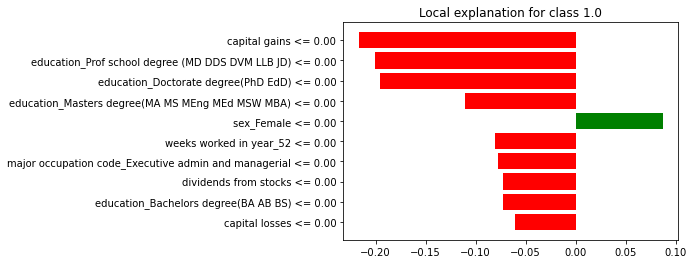

Actual label: [0.]


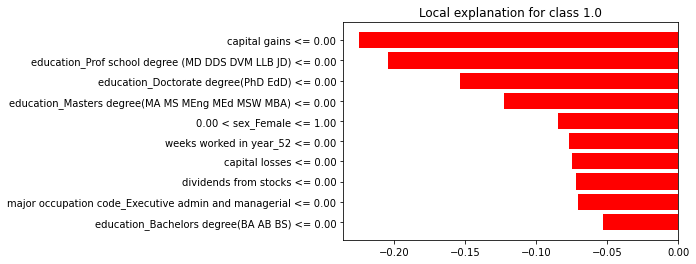

In [75]:
print(f"Threshold corresponding to best balanced accuracy: {best_thresh}")
show_explanation(0)
show_explanation(2)